## Project topic

The aim of the project is to predict high school students' ```GradeClass``` based on their demographics, study habits, parental involvement, extracurricular activities, and academic performance. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)
from tabulate import tabulate

## Data preprocessing

### Import data

In [2]:
data = pd.read_csv("/kaggle/input/d/rabieelkharoua/students-performance-dataset/Student_performance_data _.csv")
data.head(10)

,StudentID,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,1001,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,1002,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,1003,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,1004,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,1005,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0
5,1006,18,0,0,1,8.191219,0,0,1,1,0,0,0,3.084184,1.0
6,1007,15,0,1,1,15.601680,10,0,3,0,1,0,0,2.748237,2.0
7,1008,15,1,1,4,15.424496,22,1,1,1,0,0,0,1.360143,4.0
8,1009,17,0,0,0,4.562008,1,0,2,0,1,0,1,2.896819,2.0
9,1010,16,1,0,1,18.444466,0,0,3,1,0,0,0,3.573474,0.0


```StudentID``` is unique and it doesn't influence student's ```GradeClass```, so this variable isn't useful. 

In [3]:
data = data.drop(columns = 'StudentID')

### Missing values

In [4]:
data.isnull().sum()

Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
GradeClass           0
dtype: int64

There are no missing values

### Duplication

In [5]:
sum(data.duplicated())

0

There are no duplicated rows

### Basic statistics

In [6]:
round(data[['StudyTimeWeekly','Absences','GPA']].describe(),3)

,StudyTimeWeekly,Absences,GPA
count,2392.000,2392.000,2392.000
mean,9.772,14.541,1.906
std,5.653,8.467,0.915
min,0.001,0.000,0.000
25%,5.043,7.000,1.175
50%,9.705,15.000,1.893
75%,14.408,22.000,2.622
max,19.978,29.000,4.000


### Feature distribution

In [7]:
sns.set_palette('pastel')

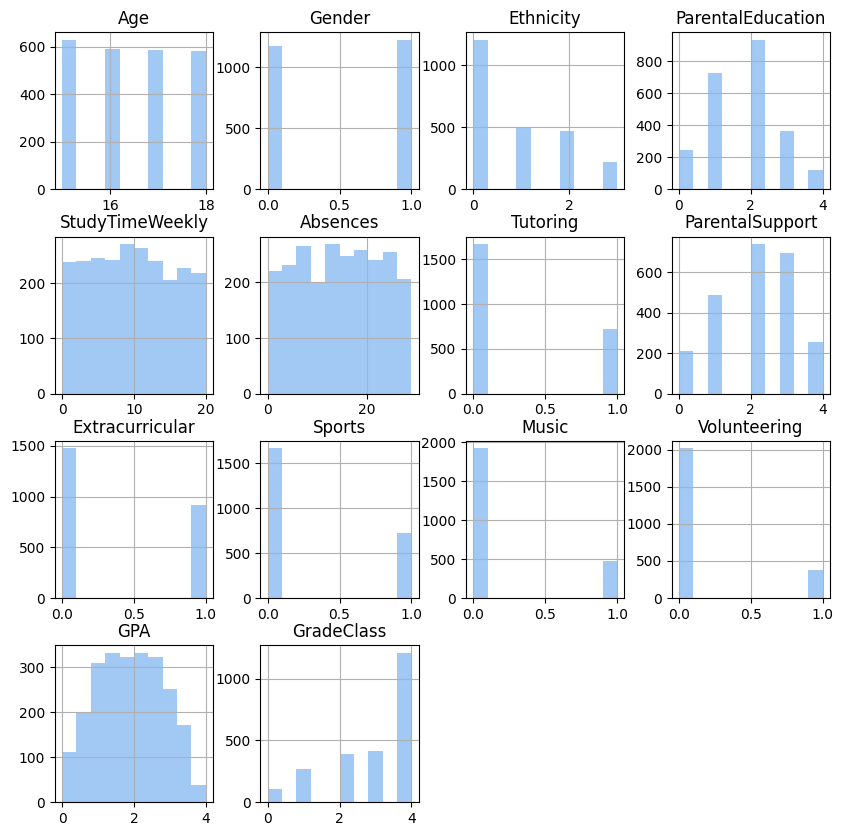

In [8]:
data.hist(figsize = (10,10))
plt.show()

We can see that there are 3 numerical variables: ```StudyTimeWeekly```, ```Absences``` and ```GPA```. The remaining variables are either categorical or boolean.

### Correlation

In [9]:
corr_matrix = data.corr()
corr_matrix.style.background_gradient(cmap = 'coolwarm').format(precision = 2)

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
Age,1.00,0.04,-0.03,0.03,-0.01,-0.01,-0.01,0.03,-0.03,-0.05,-0.00,0.01,0.00,-0.01
Gender,0.04,1.00,0.02,0.01,0.01,0.02,-0.03,0.01,-0.01,-0.01,0.01,-0.00,-0.01,0.02
Ethnicity,-0.03,0.02,1.00,0.03,0.01,-0.03,-0.02,0.02,-0.01,-0.00,-0.01,0.01,0.03,-0.02
ParentalEducation,0.03,0.01,0.03,1.00,-0.01,0.04,-0.02,-0.02,0.01,0.00,0.04,0.01,-0.04,0.04
StudyTimeWeekly,-0.01,0.01,0.01,-0.01,1.00,0.01,0.03,0.04,-0.02,0.01,0.01,-0.02,0.18,-0.13
Absences,-0.01,0.02,-0.03,0.04,0.01,1.00,-0.02,0.00,0.00,0.04,-0.01,-0.02,-0.92,0.73
Tutoring,-0.01,-0.03,-0.02,-0.02,0.03,-0.02,1.00,-0.00,0.00,0.01,-0.01,-0.05,0.15,-0.11
ParentalSupport,0.03,0.01,0.02,-0.02,0.04,0.00,-0.00,1.00,-0.01,-0.01,0.04,-0.01,0.19,-0.14
Extracurricular,-0.03,-0.01,-0.01,0.01,-0.02,0.00,0.00,-0.01,1.00,-0.01,-0.01,-0.01,0.09,-0.07
Sports,-0.05,-0.01,-0.00,0.00,0.01,0.04,0.01,-0.01,-0.01,1.00,-0.02,-0.00,0.06,-0.03


There is a strong negative correlation between ```GPA``` and ```Absences```, which indicates that as the average value of one variable increases, the average value of the other variable decreaes. Students with fewer absences tend to have higher GPA. 
There is a strong positive correlation between ```GradeClass``` and ```Absences```. This suggests that as the number of absences increases, the grade class tends to be higher, which corresponds to lower GPA.


### Change data types

```GPA``` shouldn't be used as a feature variable to predict ```GradeClass```, as they both represent the same thing. 


In [10]:
data = data.drop(columns = 'GPA')

In [11]:
data.nunique()

Age                     4
Gender                  2
Ethnicity               4
ParentalEducation       5
StudyTimeWeekly      2392
Absences               30
Tutoring                2
ParentalSupport         5
Extracurricular         2
Sports                  2
Music                   2
Volunteering            2
GradeClass              5
dtype: int64

In [12]:
data['Age'] = data['Age'].astype('category')
data['Ethnicity'] = data['Ethnicity'].astype('category')
data['ParentalEducation'] = data['ParentalEducation'].astype('category')
data['ParentalSupport'] = data['ParentalSupport'].astype('category')
data['GradeClass'] = data['GradeClass'].astype('category')

data['Gender'] = data['Gender'].astype(bool)
data['Tutoring'] = data['Tutoring'].astype(bool)
data['Extracurricular'] = data['Extracurricular'].astype(bool)
data['Sports'] = data['Sports'].astype(bool)
data['Music'] = data['Music'].astype(bool)
data['Volunteering'] = data['Volunteering'].astype(bool)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Age                2392 non-null   category
 1   Gender             2392 non-null   bool    
 2   Ethnicity          2392 non-null   category
 3   ParentalEducation  2392 non-null   category
 4   StudyTimeWeekly    2392 non-null   float64 
 5   Absences           2392 non-null   int64   
 6   Tutoring           2392 non-null   bool    
 7   ParentalSupport    2392 non-null   category
 8   Extracurricular    2392 non-null   bool    
 9   Sports             2392 non-null   bool    
 10  Music              2392 non-null   bool    
 11  Volunteering       2392 non-null   bool    
 12  GradeClass         2392 non-null   category
dtypes: bool(6), category(5), float64(1), int64(1)
memory usage: 64.2 KB


## Visualization

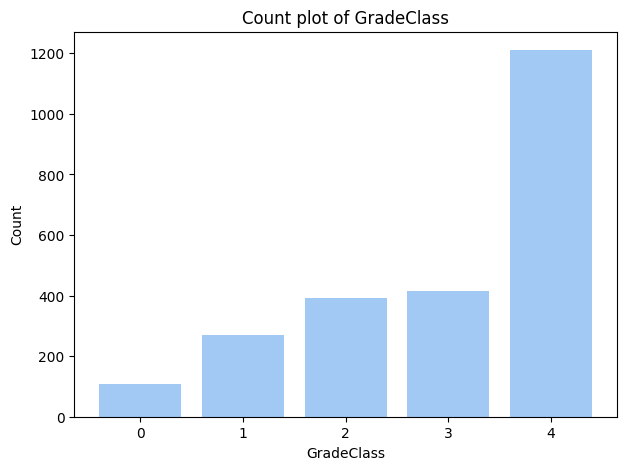

In [14]:
grade_counts = data['GradeClass'].value_counts()

plt.figure(figsize=(7,5))
plt.bar(grade_counts.index, grade_counts)
plt.xlabel('GradeClass')
plt.ylabel('Count')
plt.title('Count plot of GradeClass')
plt.show()

The target variable is imbalanced, which means we should use stratified splitting.

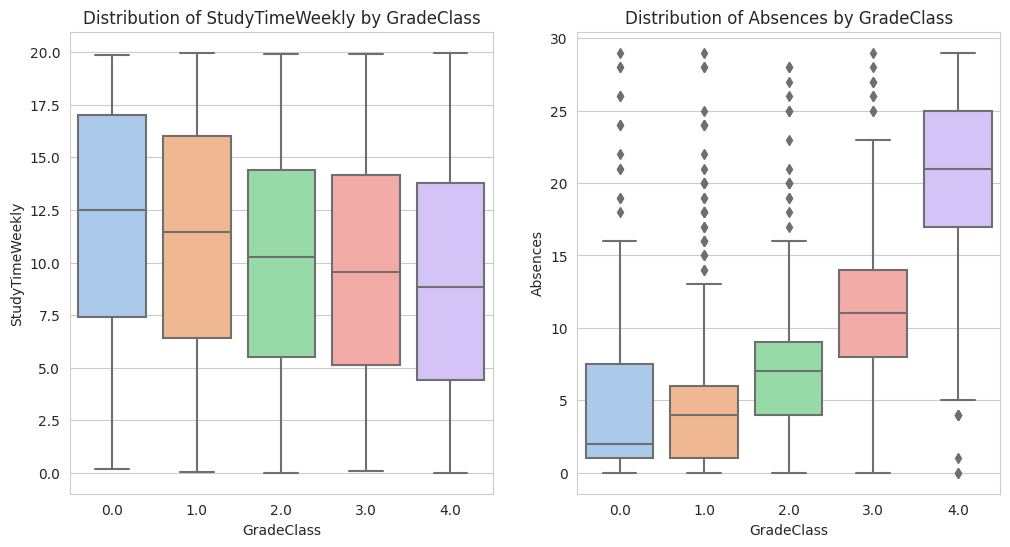

In [15]:
sns.set_style('whitegrid')
fig, axes = plt.subplots(1,2, figsize = (12,6))

sns.boxplot(y = data['StudyTimeWeekly'], x=data['GradeClass'], ax = axes[0]);
axes[0].set_title('Distribution of StudyTimeWeekly by GradeClass');

sns.boxplot(y = data['Absences'], x = data['GradeClass'], ax = axes[1]);
axes[1].set_title('Distribution of Absences by GradeClass');

The boxplot demonstrates that the median weekly study time is lower for students with higher grade class. This indicates that students who study more per week tend to have better grades compared to students who study less. We can also see that students with fewer absences tend to have better grades. 

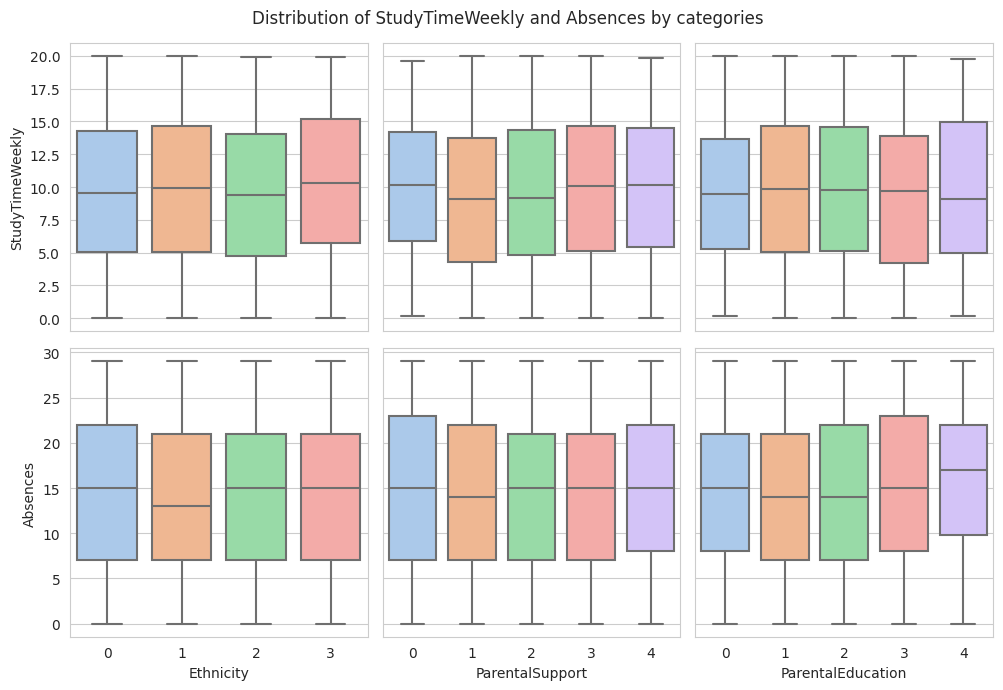

In [16]:
categories = ['Ethnicity', 'ParentalSupport', 'ParentalEducation']

fig, axes = plt.subplots(2, 3, figsize=(10, 7))
fig.suptitle('Distribution of StudyTimeWeekly and Absences by categories')

for i, category in enumerate(categories):
    sns.boxplot(y = data['StudyTimeWeekly'], x = data[category], ax = axes[0,i])
    sns.boxplot(y = data['Absences'], x = data[category], ax = axes[1,i])
    axes[0,i].set_xlabel('')
    axes[0,i].set_xticklabels([])
    if i==0:
        axes[0,i].set_ylabel('StudyTimeWeekly')
        axes[1,i].set_ylabel('Absences')
    else:
        axes[0,i].set_ylabel('')
        axes[1,i].set_ylabel('')
        axes[0,i].set_yticklabels([])
        axes[1,i].set_yticklabels([])

plt.tight_layout()
plt.show()

From the chart above, we can see that there are no significant differences in students' absences and weekly study time based on their ethnicity, parental support and parental education.

### Standarization

In [17]:
cols_to_scale = ['StudyTimeWeekly','Absences']
std_scaler = StandardScaler()
data[cols_to_scale] = std_scaler.fit_transform(data[cols_to_scale])

## Building models

### Splitting dataset

In [18]:
kfold = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 44)

In [19]:
X = data.drop('GradeClass', axis = 1)
y = data['GradeClass']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 44, stratify = y)

### Models

To predict students' ```GradeClass```, we will use 7 classification models: Logistic Regression, Decision Tree, Random Forest, K-nearest Neighbours, Support Vector Machines, Gaussian Naive Bayes and Gradient Boosting. 

In [20]:
classification_models = {
    'Logistic Regression': LogisticRegression(max_iter = 900),
    'Deicision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'K-nearest Neighbours': KNeighborsClassifier(),
    'SVM': SVC(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier()
}

accuracy = []
model_name = []

In [21]:
for name, clf in classification_models.items():
    score = cross_val_score(clf, X_train, y_train, cv = kfold, scoring = 'accuracy')
    score_mean = score.mean()
    model_name.append(name)
    accuracy.append(score_mean)

In [22]:
results = pd.DataFrame({'Model': model_name, 'Accuracy': accuracy})
round(results,3)

,Model,Accuracy
0,Logistic Regression,0.701
1,Deicision Tree,0.601
2,Random Forest,0.692
3,K-nearest Neighbours,0.604
4,SVM,0.624
5,Gaussian Naive Bayes,0.653
6,Gradient Boosting,0.699


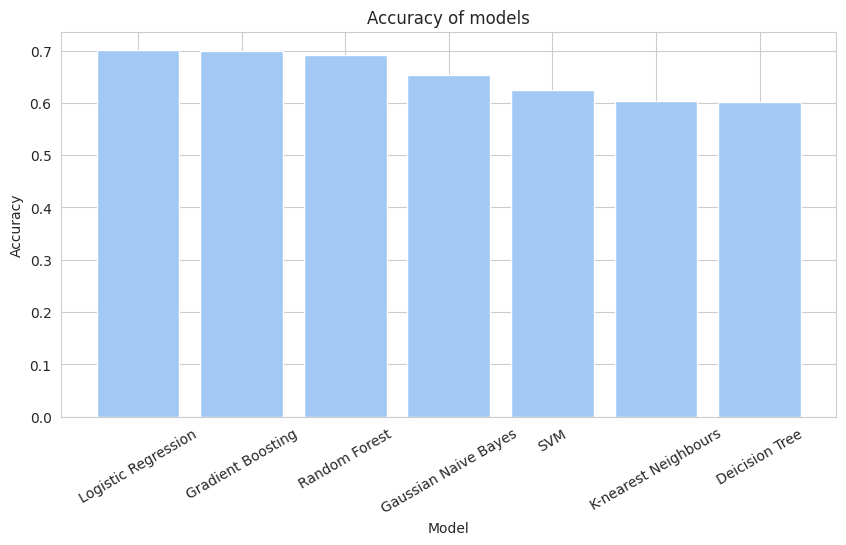

In [23]:
results_sorted = results.sort_values('Accuracy', ascending = False)

plt.figure(figsize=(10,5))
plt.bar(results_sorted['Model'], results_sorted['Accuracy'])
plt.xlabel('Model')
plt.xticks(rotation = 30)
plt.ylabel('Accuracy')
plt.title('Accuracy of models')
plt.show()

The best-performing model is Logistic Regression, achieving an accuracy of 70.1%.

### Hyperparameter tuning

In [24]:
log_reg = LogisticRegression(random_state = 44, max_iter = 1500)

grid = {'C': 10**np.linspace(-3,3,20),
        'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']
       }

log_reg_cv = GridSearchCV(log_reg, grid, cv = 10)
log_reg_cv.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=LogisticRegression(max_iter=1500, random_state=44),
             param_grid={'C': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03]),
                         'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']})

In [25]:
print(log_reg_cv.best_params_)
print(log_reg_cv.best_score_)

{'C': 54.555947811685144, 'solver': 'saga'}
0.7051892452006981


After conducting hyperparameter tuning, the logistic regression model achieved an accuracy of 70.5%.

### Model evaluation

In [26]:
accuracy = round(log_reg_cv.score(X_test, y_test),3)
y_pred = log_reg_cv.predict(X_test)
print(accuracy)

0.749


The model's accuracy on the test set is 74.9%.

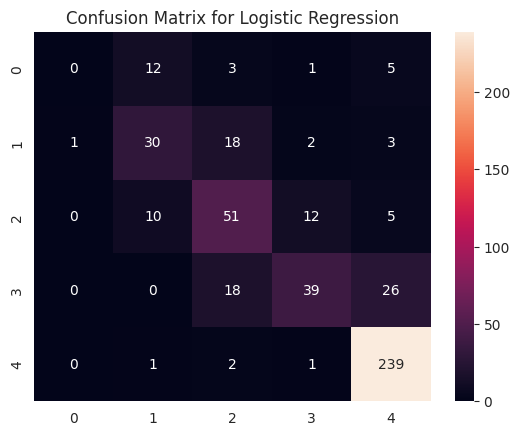

In [27]:
conf_mat = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_mat, annot = True, fmt = ".0f").set_title('Confusion Matrix for Logistic Regression');